<a href="https://colab.research.google.com/github/khanhtran0259/PotatoDiseases/blob/main/PotatoDiseases_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle datasets download -d hafiznouman786/potato-plant-diseases-data

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data
License(s): CC0-1.0
 96% 73.0M/75.7M [00:03<00:00, 18.8MB/s]
100% 75.7M/75.7M [00:03<00:00, 19.9MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('/content/potato-plant-diseases-data.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
import os
for dirpath , dirname, filename in os.walk('PlantVillage'):
  print(f"There are  {len(dirname)} directories and {len(filename)} image in '{dirpath}'.")

There are  1 directories and 0 image in 'PlantVillage'.
There are  3 directories and 0 image in 'PlantVillage/PlantVillage'.
There are  0 directories and 152 image in 'PlantVillage/PlantVillage/Potato___healthy'.
There are  0 directories and 1000 image in 'PlantVillage/PlantVillage/Potato___Early_blight'.
There are  0 directories and 1000 image in 'PlantVillage/PlantVillage/Potato___Late_blight'.


In [4]:
import shutil
import random
#/content/PlantVillage/PlantVillage/Potato___healthy
# Set the seed for reproducibility
random.seed(42)
base_dir = '/content/PlantVillage/PlantVillage'
categories = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
output_dirs = ['train', 'val', 'test']

In [5]:
for output_dir in output_dirs:
    for category in categories:
        os.makedirs(os.path.join(base_dir, output_dir, category), exist_ok=True)

# Split data
for category in categories:
    category_path = os.path.join(base_dir, category)
    images = os.listdir(category_path)
    random.shuffle(images)

    train_split = int(0.8 * len(images))
    val_split = int(0.1 * len(images)) + train_split

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for image in train_images:
        train_dir = os.path.join(base_dir, 'train', category)
        if not os.path.exists(train_dir):
            os.makedirs(train_dir)
        shutil.copy(os.path.join(category_path, image), os.path.join(train_dir, image))

    for image in val_images:
        val_dir = os.path.join(base_dir, 'val', category)
        if not os.path.exists(val_dir):
            os.makedirs(val_dir)
        shutil.copy(os.path.join(category_path, image), os.path.join(val_dir, image))

    for image in test_images:
        test_dir = os.path.join(base_dir, 'test', category)
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
        shutil.copy(os.path.join(category_path, image), os.path.join(test_dir, image))

print("Done.")

Done.


In [6]:
train_dir = '/content/PlantVillage/PlantVillage/train'
val_dir = '/content/PlantVillage/PlantVillage/val'
test_dir = '/content/PlantVillage/PlantVillage/test'

In [7]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_name = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_name)

['Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy']


In [8]:
#function visualize image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def view_random_image(target_dir, target_class):
  #target dir
  target_folder = target_dir+"/"+target_class
  #Get random img
  random_img = random.sample(os.listdir(target_folder), 1)
  # read and plot image
  img = mpimg.imread(target_folder+ "/" +   random_img[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  #show img shape
  print(f"Image shape: {img.shape}")
  return img

Image shape: (256, 256, 3)


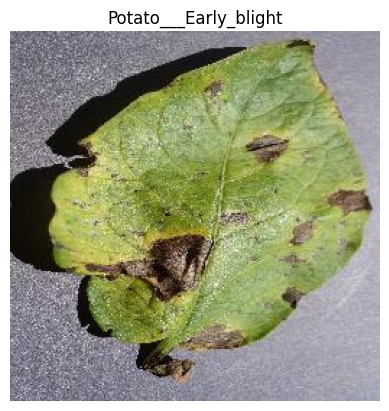

In [9]:
img = view_random_image(target_dir = train_dir, target_class=random.choice(class_name))

###Preprocessing image


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#rescale image
train_data_gen = ImageDataGenerator(rescale=1/255.)
val_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)

#
train_data = train_data_gen.flow_from_directory(train_dir, target_size=(224,224), batch_size = 32, class_mode='categorical')
val_data = val_data_gen.flow_from_directory(val_dir, target_size=(224,224), batch_size = 32, class_mode='categorical')
test_data = test_data_gen.flow_from_directory(test_dir, target_size=(224,224), batch_size = 32, class_mode='categorical')


Found 1721 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
Found 216 images belonging to 3 classes.


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation

#build model
model = Sequential([
    Conv2D(10, 3, input_shape=(224,224,3)),
    Activation(activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(3, activation='softmax')
])

In [12]:
#Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [13]:
#Fit the model
history = model.fit(train_data, epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/5
54/54 [==============================] - 14s 128ms/step - loss: 0.6403 - accuracy: 0.7310 - val_loss: 0.3701 - val_accuracy: 0.8651
Epoch 2/5
54/54 [==============================] - 5s 83ms/step - loss: 0.2452 - accuracy: 0.9030 - val_loss: 0.1839 - val_accuracy: 0.9349
Epoch 3/5
54/54 [==============================] - 3s 63ms/step - loss: 0.1353 - accuracy: 0.9471 - val_loss: 0.1052 - val_accuracy: 0.9581
Epoch 4/5
54/54 [==============================] - 4s 65ms/step - loss: 0.0874 - accuracy: 0.9686 - val_loss: 0.0955 - val_accuracy: 0.9535
Epoch 5/5
54/54 [==============================] - 4s 70ms/step - loss: 0.0652 - accuracy: 0.9768 - val_loss: 0.0768 - val_accuracy: 0.9674


In [14]:
model.evaluate(test_data)

7/7 [==============================] - 1s 105ms/step - loss: 0.0979 - accuracy: 0.9630


[0.09786048531532288, 0.9629629850387573]

In [15]:
#plot validation and training
def plot_loss_curves(history):
  loss= history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))

  #plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

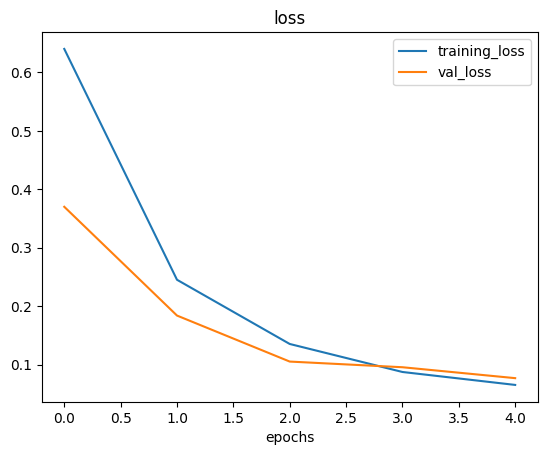

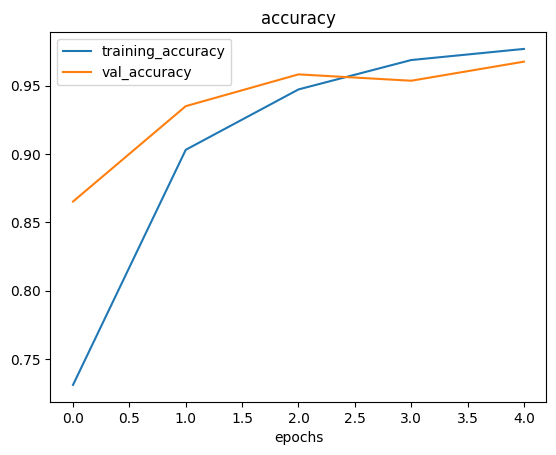

In [16]:
plot_loss_curves(history)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 activation (Activation)     (None, 222, 222, 10)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 10)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 conv2d_2 (Conv2D)           (None, 107, 107, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

In [18]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [19]:
def pred_plot(model, filename, class_name):
  img = load_and_prep_image(filename)
  pred = model.predict(tf.expand_dims(img, axis=0))
  # Get the index of the class with the highest probability
  pred_class_index = tf.argmax(pred, axis=1)
  # Use the index to get the class name
  pred_class = class_name[pred_class_index]
  plt.imshow(img)
  plt.title(f"Prediction:{pred_class}")
  plt.axis(False)

In [20]:
#late blight
!wget https://cropscience.bayer.co.uk/media/104571097/late-blight-potato-plant.jpg?width=401px&height=301px
!wget https://spudsmart.com/wp-content/uploads/2017/05/potato_late-blight_08_zoom-Photo-OMAFRA-900x580.jpeg

#early blight
!wget https://vegpath.plantpath.wisc.edu/wp-content/uploads/sites/210/2023/11/potato-early-blight-leaves.jpg
!wget https://images.ctfassets.net/l2hapltrg3cz/32lFKOCYJtoBvt5LgoAHPz/9606e6c4529327971a84824f3e8fc52f/early-blight-potatoes.jpg

#healthy

!wget https://www.garden.eco/wp-content/uploads/2018/06/can-you-eat-potato-leaves.jpg
!wget https://previews.123rf.com/images/fotografiecor/fotografiecor1908/fotografiecor190800160/129024538-green-potato-plant-leaf-of-vegetable-organic-food-agriculture-in-garden-field-or-farm-growth-of-crop.jpg



--2024-06-04 02:59:02--  https://cropscience.bayer.co.uk/media/104571097/late-blight-potato-plant.jpg?width=401px
Resolving cropscience.bayer.co.uk (cropscience.bayer.co.uk)... 20.254.175.238
Connecting to cropscience.bayer.co.uk (cropscience.bayer.co.uk)|20.254.175.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 269381 (263K) [image/jpeg]
Saving to: ‘late-blight-potato-plant.jpg?width=401px’

late-blight-potato- 100%[===================>] 263.07K  --.-KB/s    in 0.04s   

2024-06-04 02:59:02 (6.25 MB/s) - ‘late-blight-potato-plant.jpg?width=401px’ saved [269381/269381]

--2024-06-04 02:59:02--  https://spudsmart.com/wp-content/uploads/2017/05/potato_late-blight_08_zoom-Photo-OMAFRA-900x580.jpeg
Resolving spudsmart.com (spudsmart.com)... 172.67.188.28, 104.21.7.245, 2606:4700:3036::6815:7f5, ...
Connecting to spudsmart.com (spudsmart.com)|172.67.188.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105807 (103K) [image/jpeg]
Savi

1/1 [==============================] - 0s 29ms/step


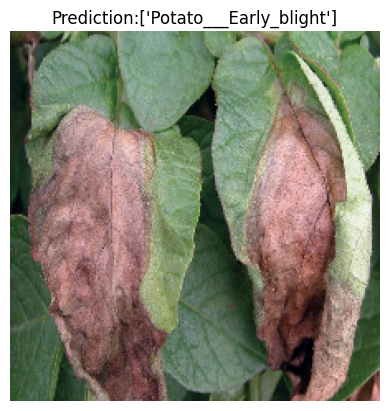

In [53]:
pred_plot(model, '/content/potato_late-blight_08_zoom-Photo-OMAFRA-900x580.jpeg', class_name)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
#improve model by removing layer
model_1 = Sequential([
    Conv2D(10, 3, input_shape=(224,224,3)),
    Activation(activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(3, activation='softmax')
])



In [34]:
model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [35]:
history_1 = model_1.fit(train_data, epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/5
54/54 [==============================] - 5s 81ms/step - loss: 0.8296 - accuracy: 0.6926 - val_loss: 0.4346 - val_accuracy: 0.8558
Epoch 2/5
54/54 [==============================] - 3s 64ms/step - loss: 0.3436 - accuracy: 0.8762 - val_loss: 0.2720 - val_accuracy: 0.9116
Epoch 3/5
54/54 [==============================] - 3s 61ms/step - loss: 0.2096 - accuracy: 0.9175 - val_loss: 0.2596 - val_accuracy: 0.8930
Epoch 4/5
54/54 [==============================] - 4s 80ms/step - loss: 0.1573 - accuracy: 0.9431 - val_loss: 0.1841 - val_accuracy: 0.9302
Epoch 5/5
54/54 [==============================] - 3s 62ms/step - loss: 0.0877 - accuracy: 0.9768 - val_loss: 0.1595 - val_accuracy: 0.9256


In [36]:
model_1.evaluate(test_data)

7/7 [==============================] - 0s 49ms/step - loss: 0.1679 - accuracy: 0.9537


[0.16791985929012299, 0.9537037014961243]

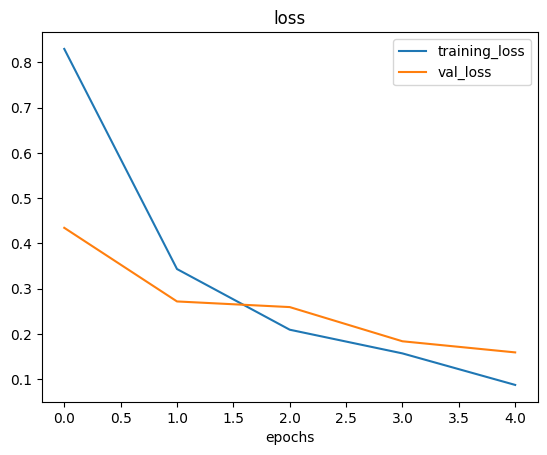

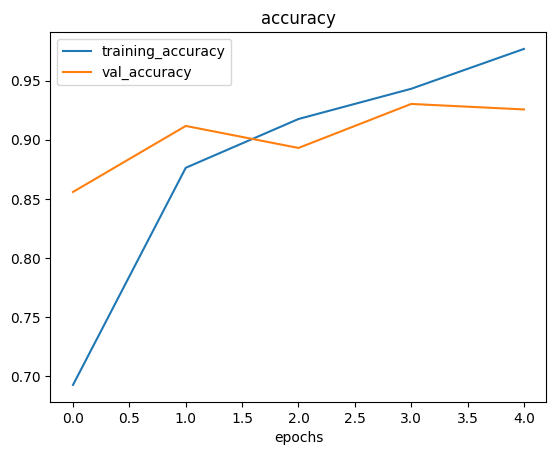

In [37]:
plot_loss_curves(history_1)

1/1 [==============================] - 0s 18ms/step


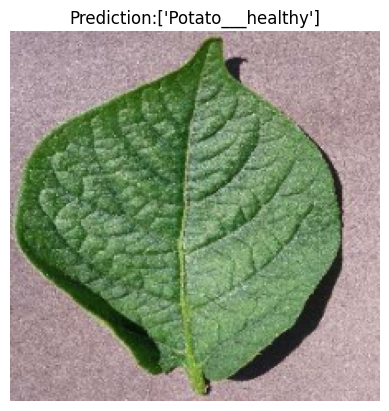

In [47]:
pred_plot(model_1, '/content/PotatoPlants/Potato___healthy/f5bd2732-197b-4d8e-bb50-a4966dc416f5___RS_HL 1840.JPG', class_name)

In [55]:
#fix overfitting with data augmentation
train_datagen_aug = ImageDataGenerator(rescale=1/255.,
                                       rotation_range=0.2,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)
train_data_aug = train_datagen_aug.flow_from_directory(train_dir,
                                                       target_size=(224,224),
                                                       batch_size=32,
                                                       class_mode='categorical')


Found 1721 images belonging to 3 classes.


In [57]:
model_2 = Sequential([
    Conv2D(64, kernel_size =(3,3) ,activation ='relu', input_shape = (224,224,3)),
    MaxPool2D((2,2)),

    Conv2D(64, kernel_size =(3,3) ,activation ='relu'),
    MaxPool2D((2,2)),

    Conv2D(64, kernel_size =(3,3) ,activation ='relu'),
    MaxPool2D((2,2)),

    Conv2D(64, (3,3) ,activation ='relu'),
    MaxPool2D((2,2)),

    Conv2D(64,(3,3) ,activation ='relu'),
    MaxPool2D((2,2)),

    Conv2D(64, (3,3) ,activation ='relu'),
    MaxPool2D((2,2)),

    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(3 , activation = 'softmax'),
])

In [58]:
model_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [59]:
history_2 = model_2.fit(train_data_aug , epochs=5,
                    steps_per_epoch=len(train_data_aug),
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/5
54/54 [==============================] - 29s 445ms/step - loss: 0.9216 - accuracy: 0.4759 - val_loss: 0.9113 - val_accuracy: 0.4651
Epoch 2/5
54/54 [==============================] - 23s 428ms/step - loss: 0.8615 - accuracy: 0.5003 - val_loss: 0.7941 - val_accuracy: 0.6047
Epoch 3/5
54/54 [==============================] - 26s 489ms/step - loss: 0.6863 - accuracy: 0.6810 - val_loss: 0.6277 - val_accuracy: 0.7209
Epoch 4/5
54/54 [==============================] - 23s 425ms/step - loss: 0.5960 - accuracy: 0.7333 - val_loss: 0.4340 - val_accuracy: 0.8698
Epoch 5/5
54/54 [==============================] - 23s 432ms/step - loss: 0.4999 - accuracy: 0.7786 - val_loss: 0.4026 - val_accuracy: 0.8419


In [60]:
model_2.evaluate(test_data)

7/7 [==============================] - 2s 249ms/step - loss: 0.3455 - accuracy: 0.8519


[0.3454734981060028, 0.8518518805503845]

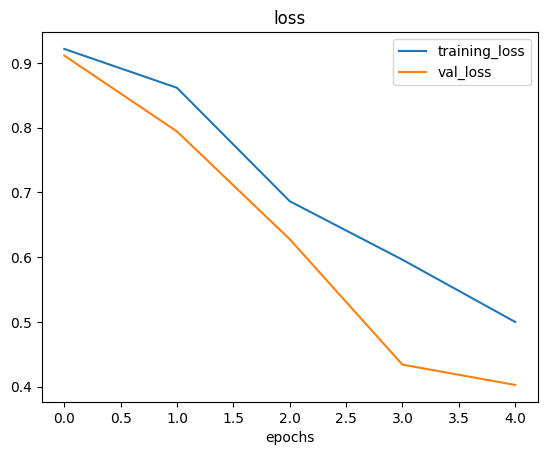

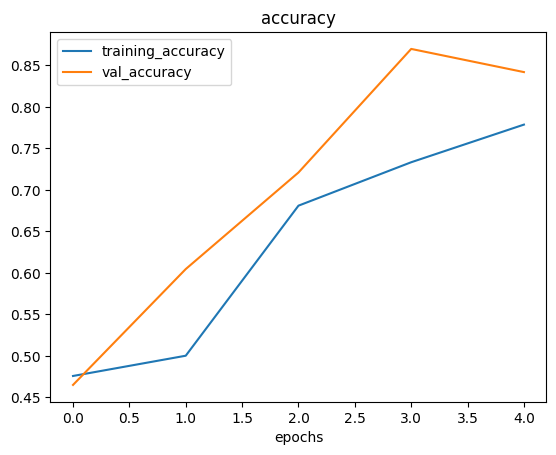

In [61]:
plot_loss_curves(history_2)

In [64]:
!wget https://spudsmart.com/wp-content/uploads/2017/07/potato_late-blight_07_zoom-Photo-OMAFRA-900x580.jpeg

--2024-06-04 04:11:15--  https://spudsmart.com/wp-content/uploads/2017/07/potato_late-blight_07_zoom-Photo-OMAFRA-900x580.jpeg
Resolving spudsmart.com (spudsmart.com)... 104.21.7.245, 172.67.188.28, 2606:4700:3037::ac43:bc1c, ...
Connecting to spudsmart.com (spudsmart.com)|104.21.7.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74053 (72K) [image/jpeg]
Saving to: ‘potato_late-blight_07_zoom-Photo-OMAFRA-900x580.jpeg’

potato_late-blight_ 100%[===================>]  72.32K  --.-KB/s    in 0.008s  

2024-06-04 04:11:15 (9.08 MB/s) - ‘potato_late-blight_07_zoom-Photo-OMAFRA-900x580.jpeg’ saved [74053/74053]



1/1 [==============================] - 0s 18ms/step


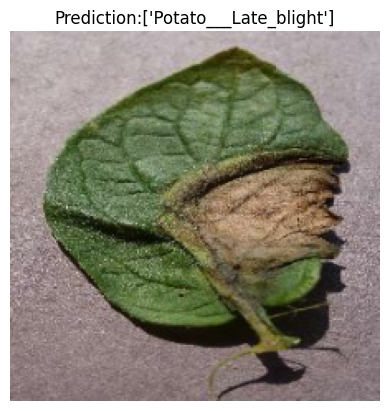

In [73]:
pred_plot(model_2, '/content/PlantVillage/PlantVillage/test/Potato___Late_blight/d78c58b2-c9d1-43f2-8b18-4455855c0f1f___RS_LB 3288.JPG', class_name)